In [ ]:
import cv2
import matplotlib.colors
import requests
import tempfile

In [ ]:
url = "http://opencv-code.com/wp-content/uploads/perspective-quadrilateral-src-img.jpg"
with tempfile.NamedTemporaryFile() as f:
    f.write(requests.get(url).content)
    src = cv2.imread(f.name)

assert src is not None and len(src), "Empty"

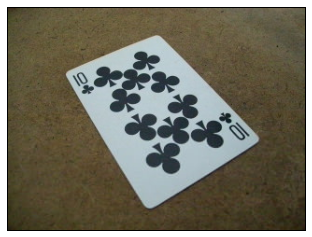

In [3]:
plt.imshow(cv2.cvtColor(src, cv2.COLOR_BGR2RGB))
_ = plt.xticks([]), plt.yticks([])

In [4]:
bw = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY)

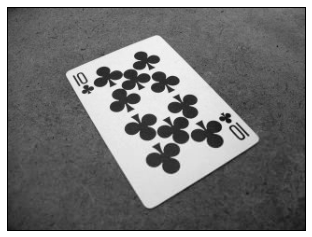

In [5]:
plt.imshow(
    bw,
    cmap="gray",
)
_ = plt.xticks([]), plt.yticks([])

In [6]:
bw_blur = cv2.blur(bw, (3, 3))

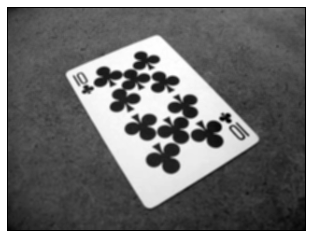

In [7]:
plt.imshow(
    bw_blur,
    cmap="gray",
)
_ = plt.xticks([]), plt.yticks([])

In [8]:
threshold_min = 100
ratio_min_max = 1
bw_canny = cv2.Canny(
    bw_blur, threshold_min, threshold_min * ratio_min_max, apertureSize=3
)

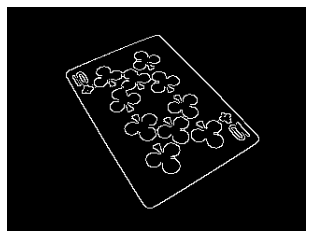

In [9]:
plt.imshow(
    bw_canny,
    cmap="gray",
)
_ = plt.xticks([]), plt.yticks([])

In [10]:
lines = cv2.HoughLinesP(bw_canny, 1, np.pi / 180, 70, minLineLength=30, maxLineGap=10)[
    0
]

In [11]:
len(lines)

4

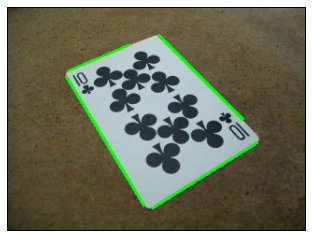

In [12]:
src_lines = src.copy()
for x1, y1, x2, y2 in lines:
    cv2.line(src_lines, (x1, y1), (x2, y2), (0, 255, 0), 2)

plt.imshow(cv2.cvtColor(src_lines, cv2.COLOR_BGR2RGB))
_ = plt.xticks([]), plt.yticks([])

In [13]:
def computeIntersect(a, b):
    x1 = a[0]
    y1 = a[1]
    x2 = a[2]
    y2 = a[3]
    x3 = b[0]
    y3 = b[1]
    x4 = b[2]
    y4 = b[3]
    d = ((x1 - x2) * (y3 - y4)) - ((y1 - y2) * (x3 - x4))

    if d:
        d = float(d)
        x = ((x1 * y2 - y1 * x2) * (x3 - x4) - (x1 - x2) * (x3 * y4 - y3 * x4)) / d
        y = ((x1 * y2 - y1 * x2) * (y3 - y4) - (y1 - y2) * (x3 * y4 - y3 * x4)) / d
        return int(x), int(y)
    else:
        return -1, -1

In [14]:
corners = []
for i, lineI in enumerate(lines):
    for lineJ in lines[i + 1 :]:
        x, y = computeIntersect(lineI, lineJ)
        if x >= 0 and y >= 0:
            corners.append((x, y))

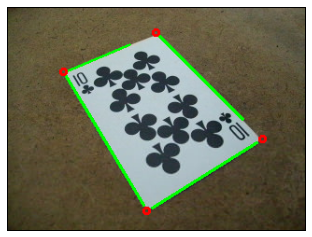

In [15]:
src_corners = src.copy()
for x1, y1, x2, y2 in lines:
    cv2.line(src_corners, (x1, y1), (x2, y2), (0, 255, 0), 2)

for x1, y1 in corners:
    cv2.circle(src_corners, (x1, y1), 3, (0, 0, 255), 2)

plt.imshow(cv2.cvtColor(src_corners, cv2.COLOR_BGR2RGB))
_ = plt.xticks([]), plt.yticks([])

In [16]:
corners_mat = np.array(corners)

In [17]:
corners = cv2.approxPolyDP(corners_mat, cv2.arcLength(corners_mat, True) * 0.02, True)
corners = np.array([x[0] for x in corners])

In [18]:
len(corners)

4

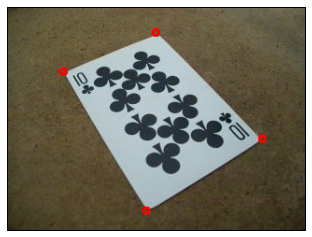

In [19]:
src_poly = src.copy()

for vert in corners:
    vert = vert
    x1, y1 = vert
    cv2.circle(src_poly, (x1, y1), 3, (0, 0, 255), 2)

plt.imshow(cv2.cvtColor(src_poly, cv2.COLOR_BGR2RGB))
_ = plt.xticks([]), plt.yticks([])

In [20]:
assert len(corners) == 4, "The object is not quadrilateral!"

In [21]:
def sortCorners(corners, center):
    top = []
    bot = []
    for corner in corners:
        if corner[1] < center[1]:
            top.append(corner)
        else:
            bot.append(corner)

    tl = top[1] if top[0][0] > top[1][0] else top[0]
    tr = top[0] if top[0][0] > top[1][0] else top[1]
    bl = bot[1] if bot[0][0] > bot[1][0] else bot[0]
    br = bot[0] if bot[0][0] > bot[1][0] else bot[1]

    return np.array((tl, tr, br, bl), np.float32)

In [22]:
center = np.mean(corners, axis=0)
corners_order = sortCorners(corners, center)

In [23]:
size = (220, 300)

In [24]:
transmtx = cv2.getPerspectiveTransform(
    corners_order, np.array([[0, 0], [size[0], 0], size, [0, size[1]]], np.float32)
)

In [25]:
quad = cv2.warpPerspective(src, transmtx, size)

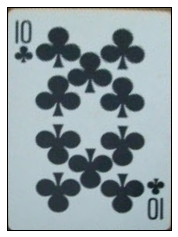

In [26]:
plt.imshow(cv2.cvtColor(quad, cv2.COLOR_BGR2RGB))
_ = plt.xticks([]), plt.yticks([])